In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('./archive/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('./archive/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


image             label
0     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
1     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
2     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
3     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
4     /kaggle/input/alzheimers-dataset-4-class-of-im...  ModerateDemented
...                                                 ...               ...
6395  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6396  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6397  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6398  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented
6399  /kaggle/input/alzheimers-dataset-4-class-of-im...      MildDemented

[6400 rows x 2 columns]

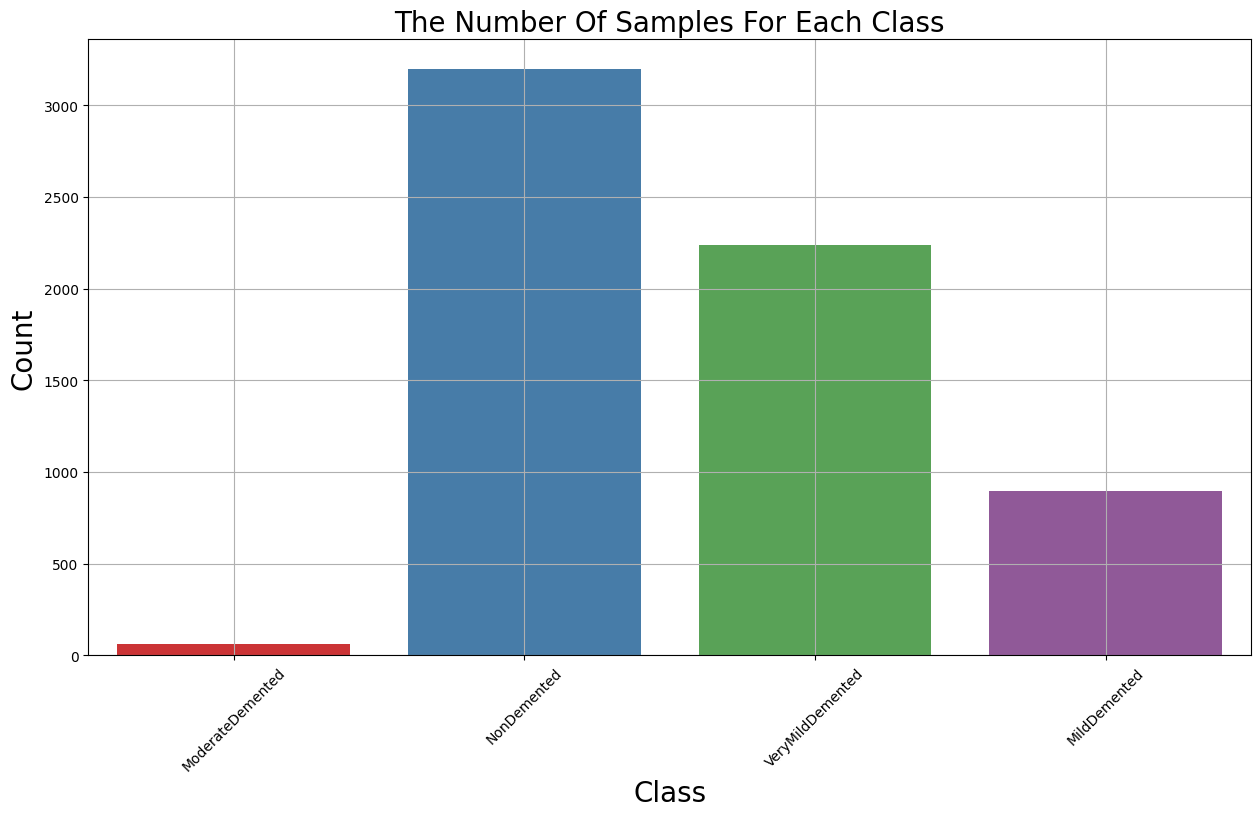

In [3]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x=df.label,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

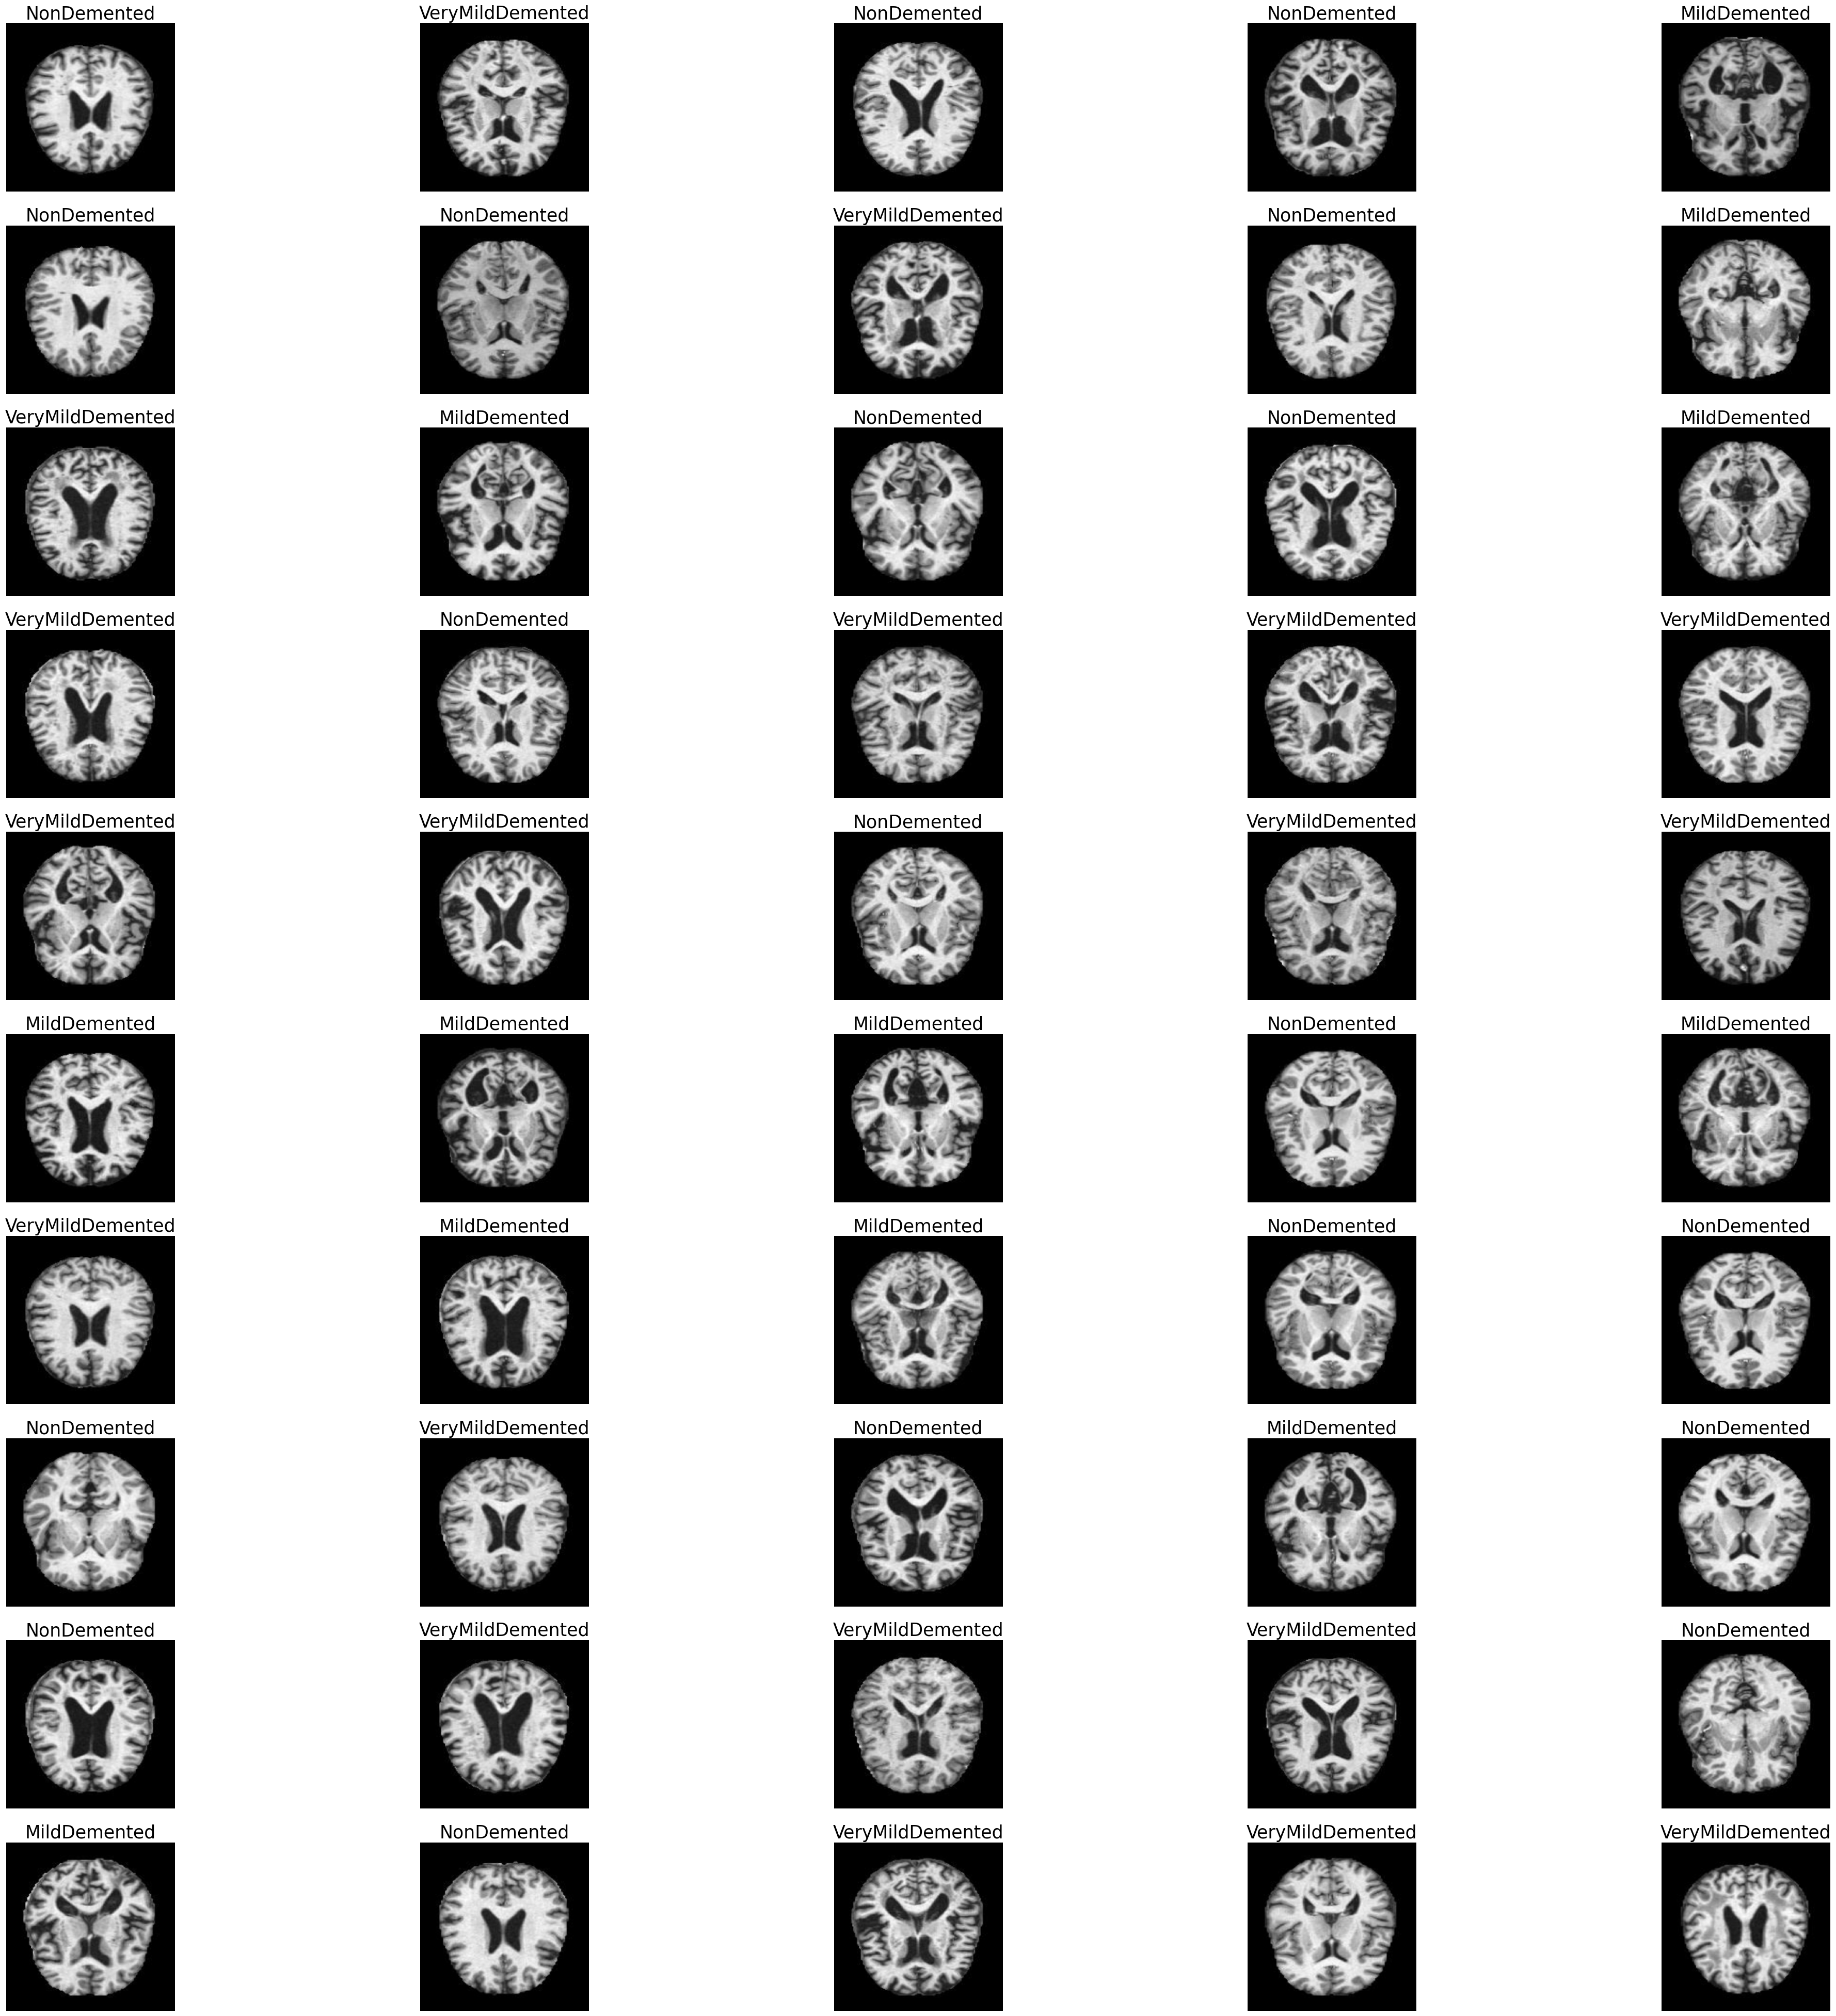

In [4]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [5]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

In [7]:
class_num=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

In [8]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


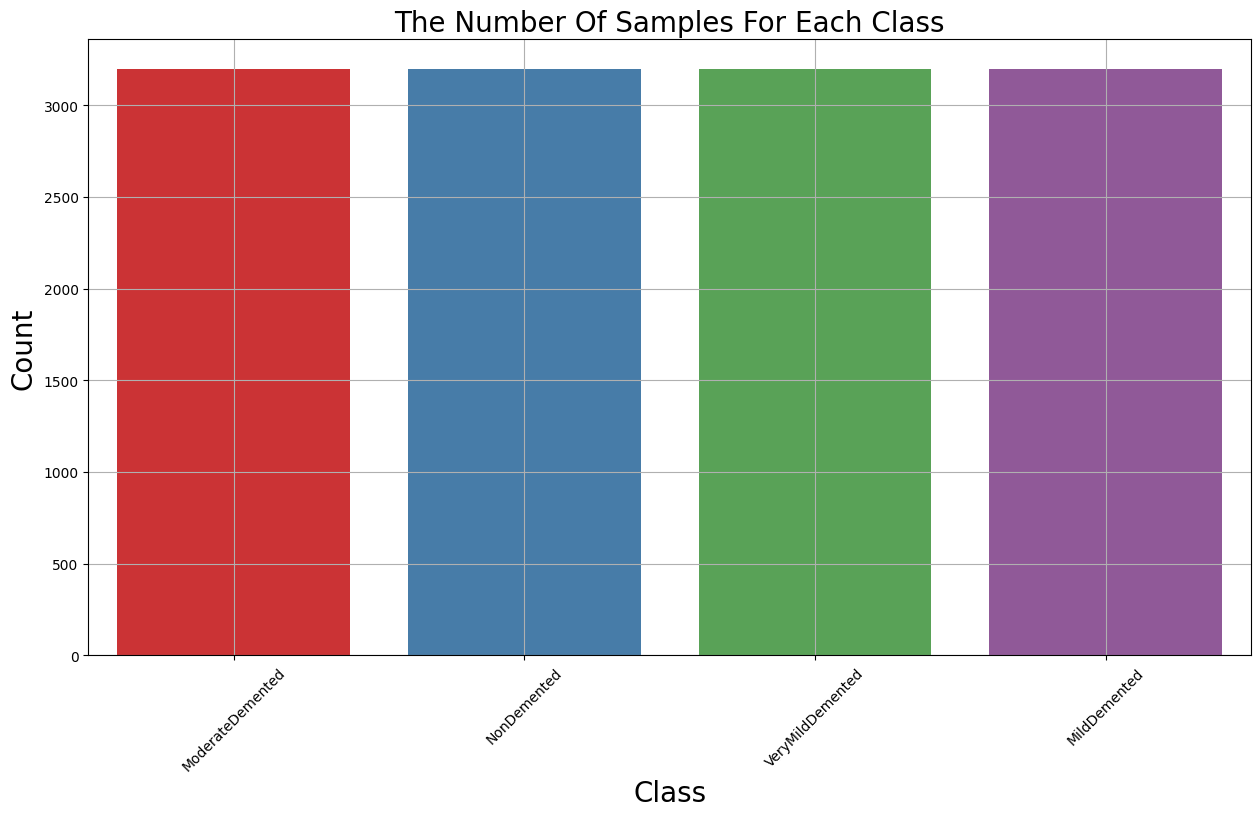

In [9]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


In [11]:
base_model = tf.keras.applications.InceptionV3(input_shape=(176,176,3),include_top=False,weights='imagenet')
base_model.trainable = False
model_Inception=keras.models.Sequential()
model_Inception.add(base_model)
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.GlobalAveragePooling2D()) 
model_Inception.add(keras.layers.Flatten()) 
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(512,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(128,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(64,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_Inception.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                         

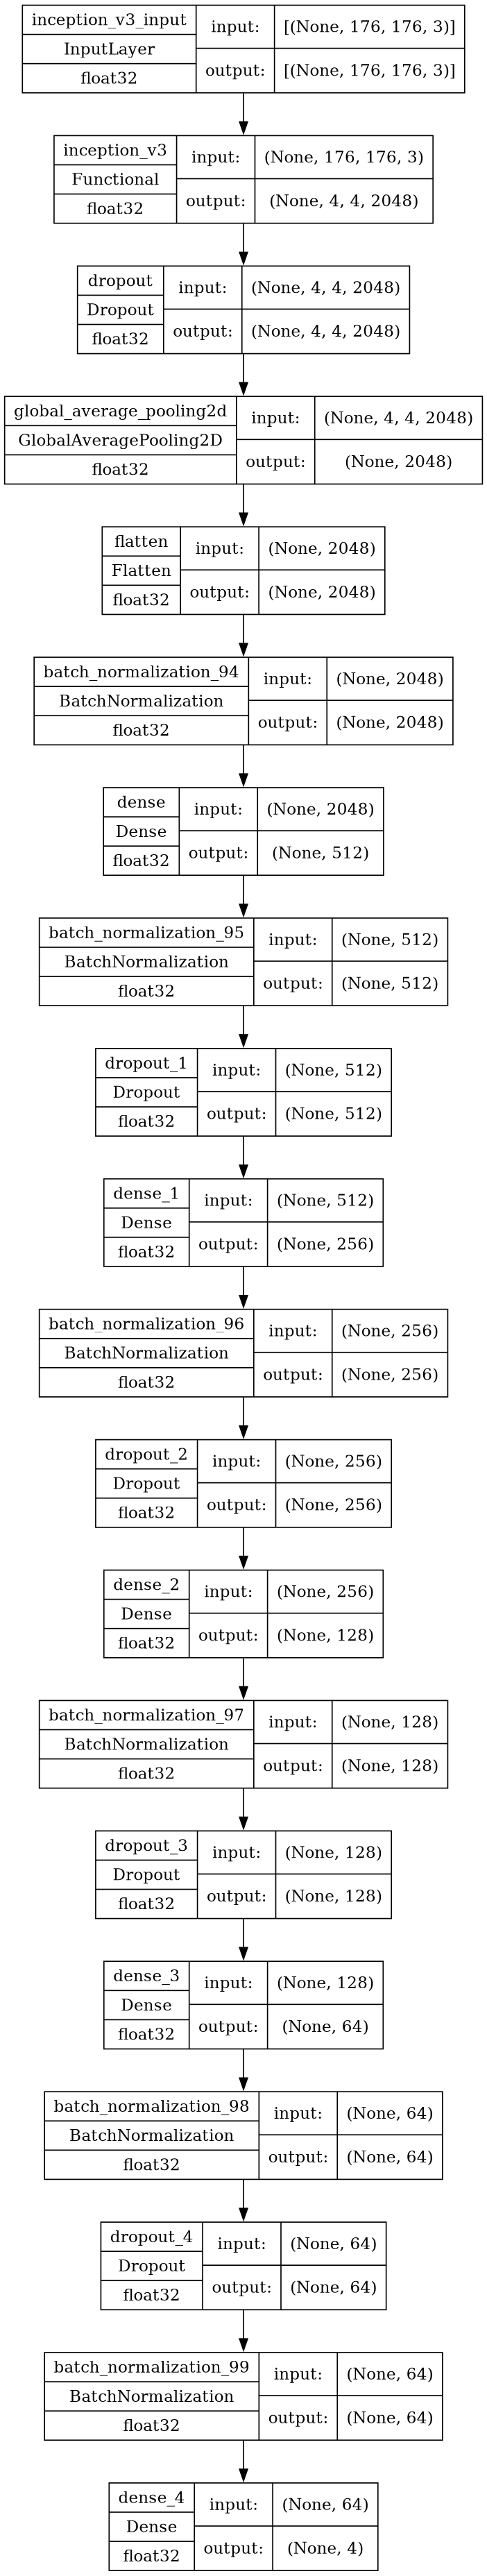

In [12]:
tf.keras.utils.plot_model(model_Inception, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [13]:
checkpoint_cb =ModelCheckpoint("model_Inception.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model_Inception.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model_Inception.fit(X_train,y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100


2023-12-29 13:58:24.153677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


280/280 [==============================] - ETA: 0s - loss: 1.3052 - accuracy: 0.4451

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 37s 74ms/step - loss: 1.3052 - accuracy: 0.4451 - val_loss: 0.7810 - val_accuracy: 0.6151
Epoch 2/100
280/280 [==============================] - 17s 59ms/step - loss: 0.9021 - accuracy: 0.5811 - val_loss: 0.6796 - val_accuracy: 0.6615
Epoch 3/100
280/280 [==============================] - 17s 60ms/step - loss: 0.7789 - accuracy: 0.6413 - val_loss: 0.6206 - val_accuracy: 0.6958
Epoch 4/100
280/280 [==============================] - 17s 61ms/step - loss: 0.7019 - accuracy: 0.6722 - val_loss: 0.5726 - val_accuracy: 0.7255
Epoch 5/100
280/280 [==============================] - 17s 62ms/step - loss: 0.6729 - accuracy: 0.7011 - val_loss: 0.5483 - val_accuracy: 0.7286
Epoch 6/100
280/280 [==============================] - 18s 63ms/step - loss: 0.6312 - accuracy: 0.7183 - val_loss: 0.5012 - val_accuracy: 0.7745
Epoch 7/100
280/280 [==============================] - 18s 64ms/step - loss: 0.5925 - accuracy: 0.7397 - val_loss: 0.4529 - val_accuracy: 0.80

In [14]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   1.305211  0.445089  0.780973      0.615104
1   0.902089  0.581138  0.679576      0.661458
2   0.778874  0.641295  0.620582      0.695833
3   0.701903  0.672210  0.572614      0.725521
4   0.672852  0.701116  0.548313      0.728646
..       ...       ...       ...           ...
95  0.098541  0.967299  0.109115      0.962500
96  0.098968  0.965737  0.109968      0.963021
97  0.107523  0.965960  0.109236      0.956250
98  0.100111  0.966518  0.111367      0.957812
99  0.092527  0.968415  0.096148      0.960938

[100 rows x 4 columns]

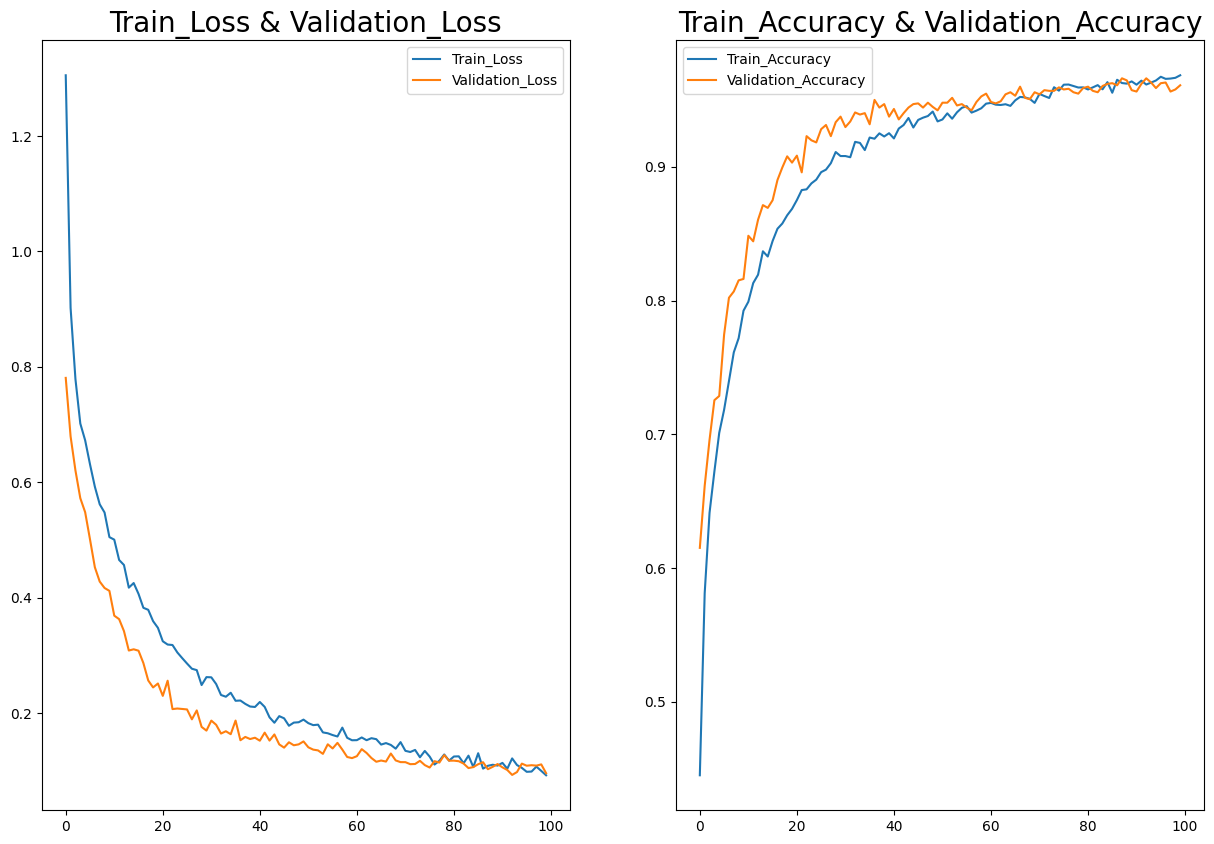

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [16]:
score, acc= model_Inception.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 3s 44ms/step - loss: 0.1323 - accuracy: 0.9568
Test Loss = 0.13230428099632263
Test Accuracy = 0.9567708373069763


In [17]:
predictions = model_Inception.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

60/60 [==============================] - 4s 43ms/step


Actual  Prediction
0          1           1
1          1           1
2          0           0
3          2           2
4          2           2
...      ...         ...
1915       2           2
1916       0           0
1917       2           2
1918       3           3
1919       3           3

[1920 rows x 2 columns]

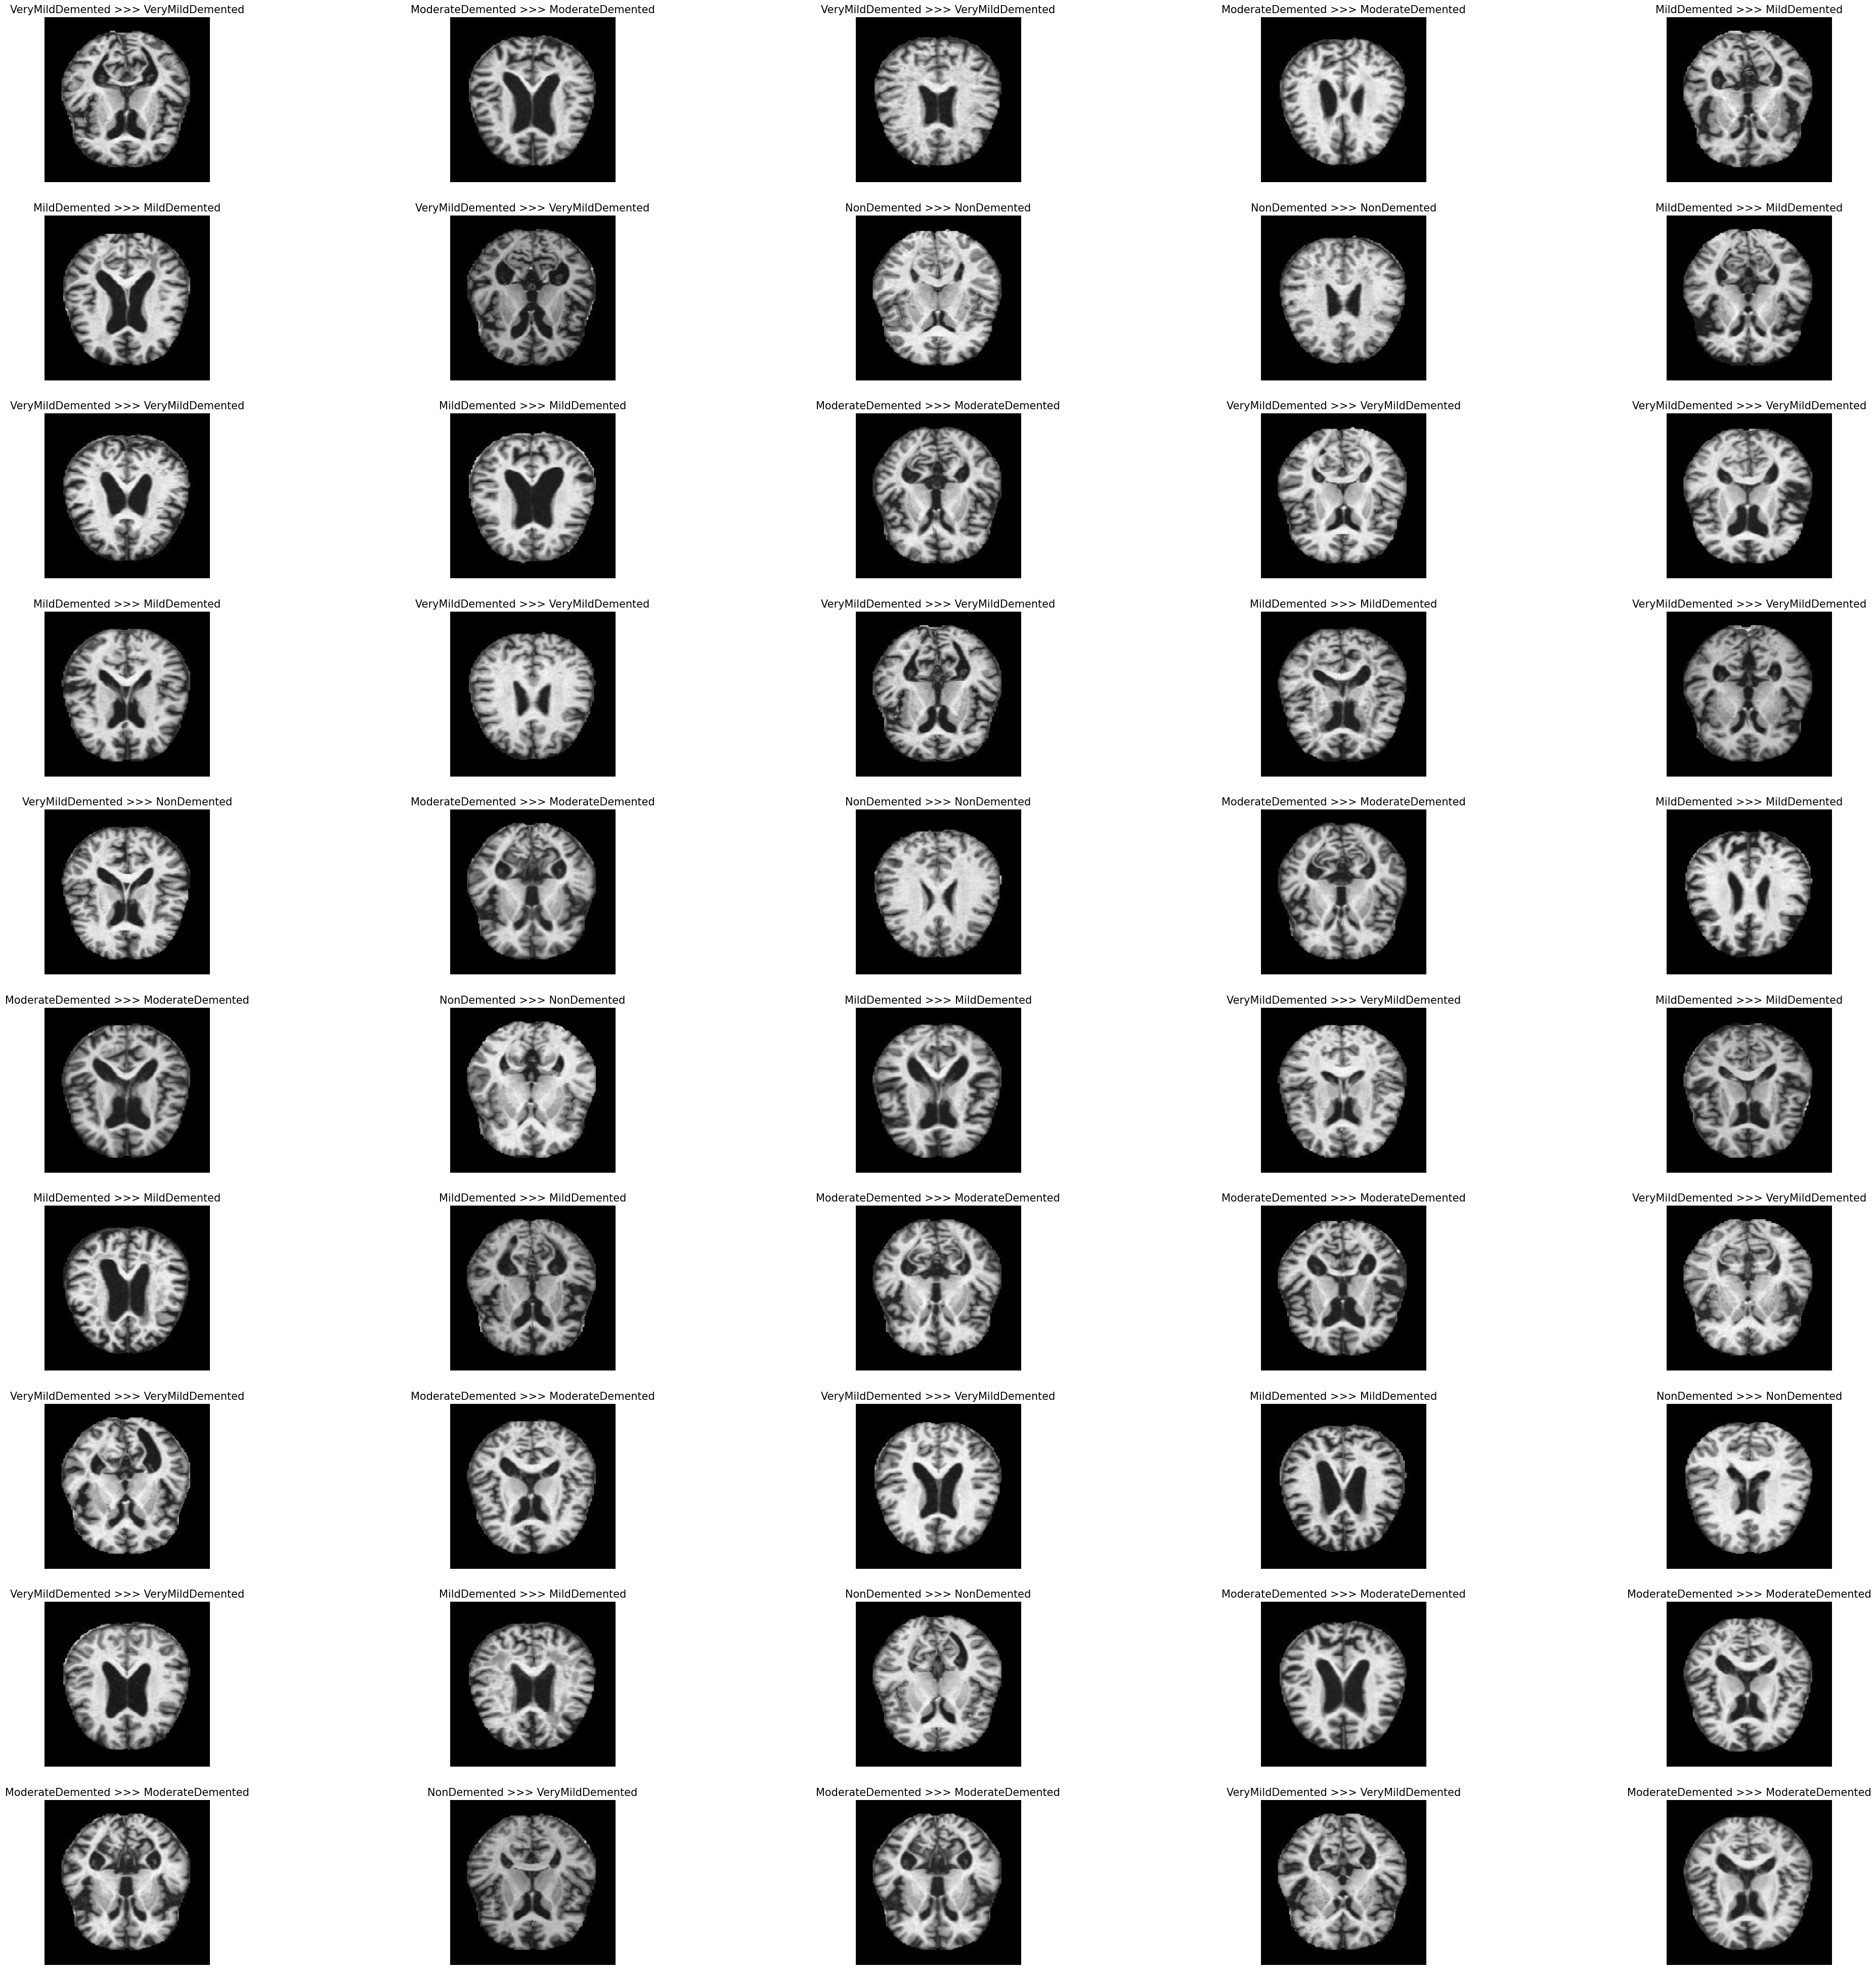

In [18]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

array([[476,   0,   0,   4],
       [  0, 480,   0,   0],
       [  9,   0, 431,  40],
       [  7,   0,  23, 450]])

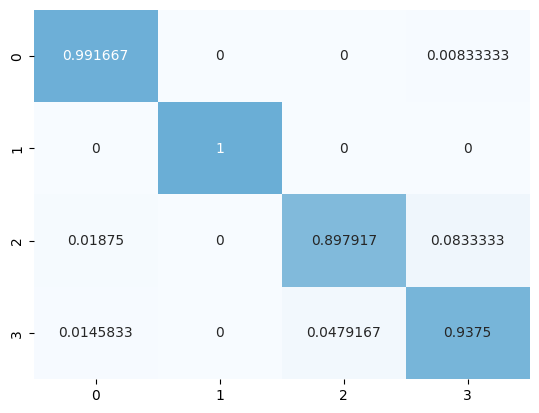

In [19]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [20]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.97      0.99      0.98       480
           1       1.00      1.00      1.00       480
           2       0.95      0.90      0.92       480
           3       0.91      0.94      0.92       480

    accuracy                           0.96      1920
   macro avg       0.96      0.96      0.96      1920
weighted avg       0.96      0.96      0.96      1920

